## Master thesis: Car Sales Forecasting in Finland using Machine Learning

### Install Required Libraries

In [ ]:
pip install xgboost

In [ ]:
pip install lightgbm

In [ ]:
pip install pycaret --user

### Loading data

In [44]:
import pandas as pd
import time

# Input path and filename
path = 'D:/Git_Projects/5. Master_thesis/Datasets/'
filename = path + 'Retails_ALL_CY11_CY22.xlsx'

start_time = time.time()

# Load files into pandas dataframes
df = pd.concat(pd.read_excel(filename, sheet_name=None), ignore_index=True)

end_time = time.time()
time_elapsed = end_time - start_time 
print('Completed in %f seconds.' % time_elapsed)

Completed in 167.159363 seconds.


### Preprocessing data

In [45]:
# As dataset having lot of extra spaces in cell so lets remove them using strip() function
df['RetailCountry'] = df['RetailCountry'].str.strip()
df['orderNumber'] = df['orderNumber'].str.strip()

In [46]:
# Sort by orderNumber and RetailDate
df.sort_values(by=['orderNumber', 'RetailDate'], inplace=True)

In [47]:
# Remove duplicates by "orderNumber"
df.drop_duplicates(subset=['orderNumber'], keep='last', inplace=True)

In [48]:
# Get only Finland orders
df = df[(df['RetailCountry'] == 'FIN')]

In [51]:
# Convert RetailDate to date
df['RetailDate'] = pd.to_datetime(df['RetailDate'], dayfirst=True).dt.date
# Get year of the ReailDate
df['year'] = pd.DatetimeIndex(df['RetailDate']).year.astype(str)
# Get month of the RetailDate
df['month'] = pd.DatetimeIndex(df['RetailDate']).month.map("{:02}".format)
# Create index as YYYYMMM
df['Date'] = df['year'].astype(str) + 'M' + df['month'].astype(str)

In [53]:
# Remove unnecessary columns
df.drop(['vehOrderClassCode', 'RetailNSC', 'NSCModelGroupCode',
       'ReportingModelGroup', 'FleetCode', 'DealerCodeRetail',
       'orderCreatedDate', 'RetailCountry', 'ModelGroup',
       'EndItem', 'EIColourCode', 'DealerDeliveryAddrNoRetail',
       'FinancialOwnerCategoryCurrent', 'FinancialOwnerCategoryNext',
       'RetailCount', 'Month', 'year', 'month', 'RetailDate'], axis=1, inplace=True)

In [54]:
# Preview dataframe
df

,orderNumber,Date
39789,NNE0103741,2012M01
5433,NNE0107709,2011M02
11142,NNE0117276,2011M04
818,NNE0119938,2011M01
1642,NNE0122350,2011M01
...,...,...
463993,NNE0655294,2022M08
463051,NNE0655400,2022M07
463050,NNE0655404,2022M07
464043,NNE0655791,2022M08


In [55]:
# Generating index by date, grouping by and counting
df = df.groupby(['Date']).size().reset_index(name='Orders')
df = df.set_index("Date")

In [56]:
# Preview dataframe
df

,Orders
Date,
2011M01,901
2011M02,671
2011M03,917
2011M04,785
2011M05,764
...,...
2022M04,316
2022M05,224
2022M06,231


In [57]:
# Save data to Excel so we don't need to run previous steps every time
df.to_excel("Datasets/Retails.xlsx")  

### ** Execution can start from here **

In [58]:
import pandas as pd

# Load files into a pandas dataframes
file = path + 'Retails.xlsx'
df = pd.concat(pd.read_excel(file, sheet_name=None), ignore_index=True)
df = df.set_index("Date")

external_file = path + 'External_indicators.xlsx'
df_ext = pd.concat(pd.read_excel(external_file, sheet_name=None), ignore_index=True)
df_ext = df_ext.set_index("Date")

In [59]:
# Merge both dataframes
data = pd.concat([df,df_ext], axis=1)

# Preview dataframe
data

,Orders,GDP,CCI,CPI,Unemployment_rate,Long_term_interest_rates,Avg_Fuel_Price
Date,,,,,,,
2011M01,901,47117,100.73760,3.037052,8.3,3.270000,1.460000
2011M02,671,47117,100.75380,3.329970,8.1,3.410000,1.460000
2011M03,917,47117,100.68170,3.300893,8.9,3.450000,1.516667
2011M04,785,49810,100.43610,3.160000,7.6,3.570000,1.526667
2011M05,764,49810,99.90539,3.344348,7.7,3.320000,1.540000
...,...,...,...,...,...,...,...
2022M04,316,68572,96.66453,5.738172,6.3,1.177000,2.216667
2022M05,224,68572,95.99726,6.962626,6.1,1.451962,2.320000
2022M06,231,68572,95.40240,7.792331,6.9,2.072276,2.560000


In [60]:
# Data statistics
data.describe()

,Orders,GDP,CCI,CPI,Unemployment_rate,Long_term_interest_rates,Avg_Fuel_Price
count,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000
mean,548.921429,55825.407143,99.492667,1.582442,8.054286,0.946106,1.556071
std,208.520139,5366.764733,1.723523,1.630154,0.918583,0.975536,0.202376
min,118.000000,47117.000000,94.494900,-0.591473,5.900000,-0.410000,1.266667
25%,402.750000,51546.000000,98.494103,0.593841,7.275000,0.176818,1.436667
50%,536.000000,55558.000000,99.145910,1.107289,8.200000,0.665000,1.526667
75%,672.000000,59209.500000,100.705950,2.262171,8.800000,1.695964,1.610833
max,1268.000000,68572.000000,102.737500,7.792331,9.900000,3.570000,2.560000


In [61]:
data.isna().sum()

Orders                      0
GDP                         0
CCI                         0
CPI                         0
Unemployment_rate           0
Long_term_interest_rates    0
Avg_Fuel_Price              0
dtype: int64

### Plotting data

array([[<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
       [<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
       [<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
       [<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
       [<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
       [<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>]],
      dtype=object)

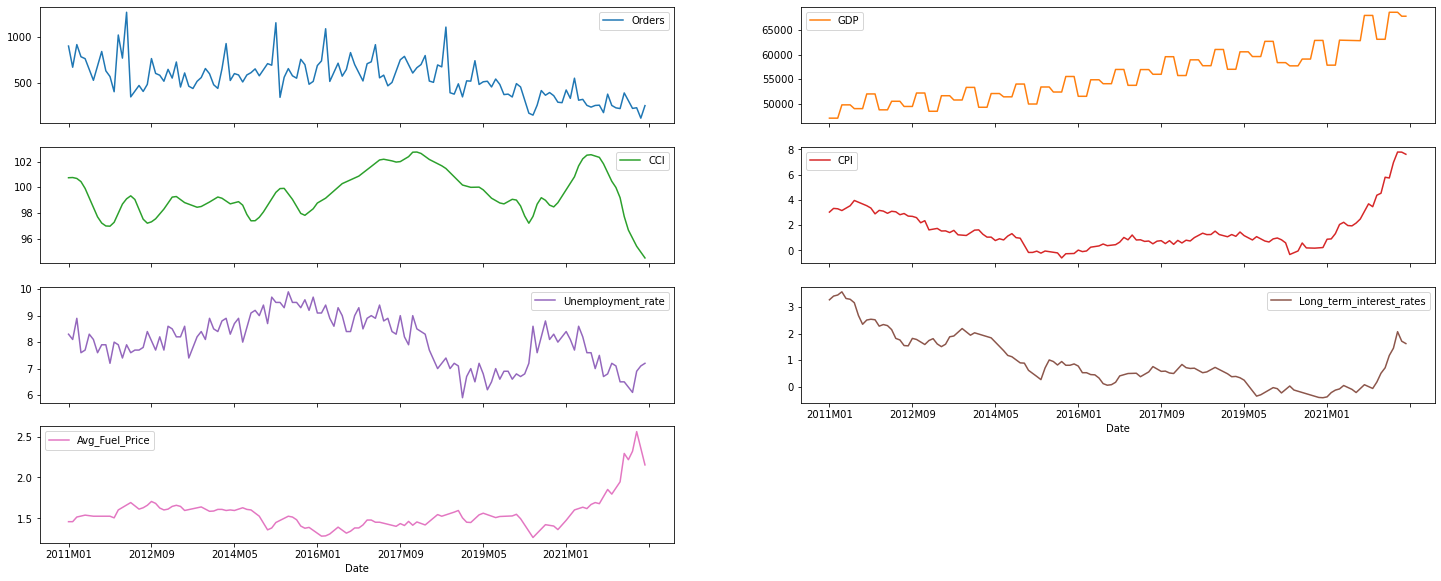

In [62]:
import matplotlib.pyplot as plt
plt.style.use('fast')
plt.rcParams["figure.figsize"] = [25, 15]
data.plot(legend=True, subplots=True, layout=(6,2))

In [2]:
# Define a function to plot the scatterplots of the relationships between 
# all independent variables and the dependent variable
def plot_relationships(df, num_cols):

    dep_var = 'Orders'                          # Dependant variable
    ind_var = df.loc[:, df.columns != 'Orders'] # Independant variables
    figs = len(df.columns) - 1                  # Number of figures 

    num_cols = num_cols
    num_rows = round(figs / num_cols) + 1
    
    fig = 1
    plt.figure(figsize=(15,15))
    
    # Loop through all independent variables and create the scatter plot
    for i in ind_var:
        plt.subplot(num_rows, num_cols, fig)
        plt.scatter(df[i], df[dep_var])
        plt.xlabel(str(i))
        plt.ylabel(str(dep_var))
        fig +=1

plot_relationships(data,3)

NameError: name 'data' is not defined

<AxesSubplot:>

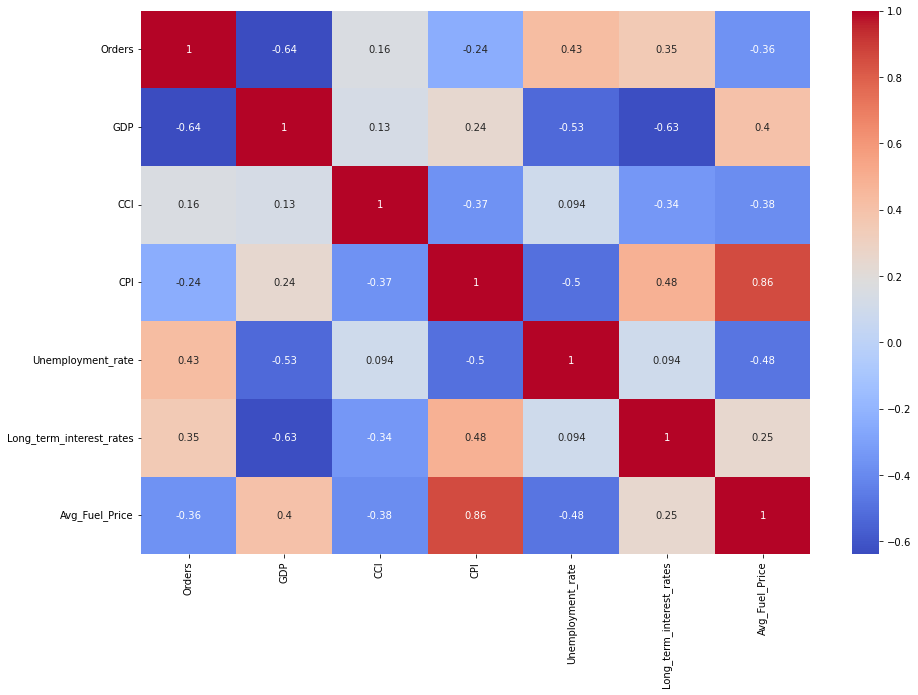

In [64]:
# Import seaborn
import seaborn as sns

# Plot the correlations as a heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt='.2g')

In [65]:
data.columns

Index(['Orders', 'GDP', 'CCI', 'CPI', 'Unemployment_rate',
       'Long_term_interest_rates', 'Avg_Fuel_Price'],
      dtype='object')

### Pandas Profiling

https://github.com/ydataai/pandas-profiling

In [66]:
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport

profile = ProfileReport(data, title="Pandas Profiling Report")

In [68]:
# Select input and target variables
X = data.drop('Orders', axis=1)
y = data["Orders"]

# Split data into train (80%) and test (20%) sets 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Print shape
X_train.shape, X_test.shape 

((112, 6), (28, 6))

### Pycaret Analysis

https://pycaret.gitbook.io/docs/

In [69]:
from pycaret.regression import *

dataset = data
data_pycaret = dataset.sample(frac=0.8, random_state=42)
data_unseen = dataset.drop(data_pycaret.index)

data_pycaret.reset_index(drop=True, inplace=True)
data_unseen.reset_index(drop=True, inplace=True)

print('Data for Modeling: ' + str(data_pycaret.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

# Initial setup
model_setup=setup(data=data_pycaret,target='Orders')

# Model training and selection
best = compare_models()

# Analyze best model
evaluate_model(best)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,97.6019,18438.6051,123.8833,0.6208,0.2370,0.2005,0.0450
xgboost,Extreme Gradient Boosting,110.0037,21454.7887,136.6558,0.5242,0.2614,0.2182,0.0250
gbr,Gradient Boosting Regressor,108.1516,21539.2480,139.4043,0.5017,0.2636,0.2226,0.0140
ada,AdaBoost Regressor,113.5805,24789.5875,146.9493,0.4712,0.2972,0.2649,0.0240
rf,Random Forest Regressor,111.9405,24731.5079,144.7595,0.4632,0.2761,0.2494,0.0560
br,Bayesian Ridge,130.8829,31270.5045,161.6262,0.3959,0.3133,0.2913,0.0080
omp,Orthogonal Matching Pursuit,130.8586,31267.2626,161.5720,0.3956,0.3122,0.2904,0.0070
en,Elastic Net,131.9185,30228.2335,163.8404,0.3809,0.5035,0.3136,0.0090
lightgbm,Light Gradient Boosting Machine,123.1753,28834.5867,157.3027,0.3756,0.2980,0.2661,0.2440
llar,Lasso Least Angle Regression,134.1099,31405.7133,166.7984,0.3589,0.4617,0.3187,0.0100


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [70]:
et = create_model('et') # Extra Trees Regressor

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,116.3588,25153.9420,158.5999,0.3869,0.2139,0.1681
1,88.0225,11676.7308,108.0589,0.4200,0.2019,0.1759
2,40.1238,2361.3451,48.5937,0.9485,0.0885,0.0780
3,108.6675,19816.0358,140.7694,0.4824,0.2423,0.2131
4,195.6137,63194.4190,251.3850,0.2897,0.3436,0.2665
5,122.3325,21512.2850,146.6707,0.6430,0.4062,0.3817
6,115.4950,21746.5232,147.4670,0.6952,0.2273,0.2103
7,61.0800,5511.4734,74.2393,0.8231,0.2740,0.2260
8,69.1757,7973.5781,89.2949,0.6991,0.2521,0.1840


In [71]:
gbr = create_model('gbr') # Gradient Boosting Regressor

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,127.7907,24152.0407,155.4093,0.4113,0.2197,0.1994
1,125.1224,25216.6826,158.7976,-0.2526,0.2816,0.2489
2,64.2512,7868.5598,88.7049,0.8285,0.1463,0.1200
3,117.5737,19678.9143,140.2816,0.4860,0.2472,0.2323
4,164.3806,51772.8214,227.5364,0.4181,0.2974,0.2141
5,157.3975,40923.7746,202.2963,0.3209,0.4389,0.4297
6,98.4937,18788.6254,137.0716,0.7366,0.2050,0.1776
7,73.6117,7373.9604,85.8718,0.7633,0.2854,0.2529
8,80.1275,9918.9259,99.5938,0.6257,0.3347,0.2238


In [72]:
lightgbm = create_model('lightgbm') # Light Gradient Boosting Machine

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,113.7417,31339.9176,177.0308,0.2361,0.2423,0.1613
1,141.5653,27130.6425,164.7138,-0.3477,0.2935,0.2633
2,72.2691,7490.8750,86.5498,0.8367,0.1526,0.1384
3,126.6452,23742.8363,154.0871,0.3798,0.2593,0.2390
4,219.5102,86537.5181,294.1726,0.0273,0.4232,0.3014
5,216.3198,58226.1522,241.3010,0.0337,0.6388,0.7515
6,99.5767,22234.8361,149.1135,0.6883,0.2244,0.1860
7,74.5162,7328.9841,85.6095,0.7648,0.2933,0.2601
8,90.3759,12763.7446,112.9767,0.5184,0.2687,0.2316


In [73]:
xgb = create_model('xgboost') 

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,116.3372,21104.1778,145.2728,0.4856,0.2008,0.1777
1,130.3529,25541.4535,159.8169,-0.2687,0.2894,0.2533
2,82.4726,10691.4572,103.3995,0.7669,0.1836,0.1539
3,133.6886,22730.9809,150.7680,0.4063,0.2554,0.2498
4,184.6721,59186.7300,243.2832,0.3347,0.3181,0.2249
5,135.2407,33229.8744,182.2906,0.4485,0.4395,0.3858
6,135.1826,25502.2854,159.6943,0.6425,0.2414,0.2348
7,62.5053,5378.8661,73.3408,0.8274,0.2716,0.2161
8,71.9324,6778.2329,82.3300,0.7442,0.2816,0.2003


In [75]:
tuned_xgb = tune_model(xgb) # Extreme Gradient Boosting

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,78.4671,10866.1879,104.2410,0.7352,0.1424,0.1180
1,126.1664,24336.3169,156.0010,-0.2089,0.2753,0.2496
2,47.0691,4688.3995,68.4719,0.8978,0.1055,0.0795
3,116.5016,21562.6456,146.8422,0.4368,0.2483,0.2243
4,177.1843,56373.1543,237.4303,0.3663,0.3215,0.2303
5,172.0113,42107.4741,205.2011,0.3012,0.5194,0.5330
6,83.6231,12745.5973,112.8964,0.8213,0.1909,0.1690
7,68.7705,6136.1844,78.3338,0.8031,0.3004,0.2574
8,86.1187,10492.2876,102.4319,0.6041,0.3216,0.2312


In [76]:
evaluate_model(tuned_xgb)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

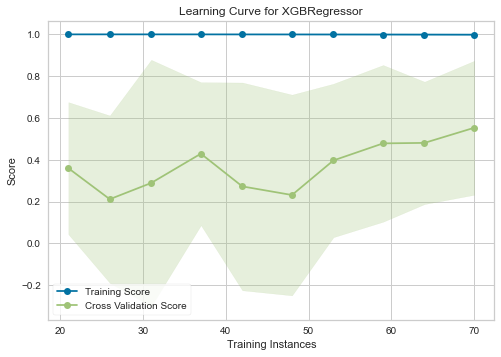

In [77]:
#+-----------------------------+-------------+
#|            Name             |    Plot     |
#+-----------------------------+-------------+
#| Residuals Plot              | ‘residuals’ |
#| Prediction Error Plot       | ‘error’     |
#| Cooks Distance Plot         | ‘cooks’     |
#| Recursive Feature Selection | ‘rfe’       |
#| Learning Curve              | ‘learning’  |
#| Validation Curve            | ‘vc’        |
#| Manifold Learning           | ‘manifold’  |
#| Feature Importance          | ‘feature’   |
#| Model Hyperparameter        | ‘parameter’ |
#+-----------------------------+-------------+

plot_model(tuned_xgb, plot ='learning')

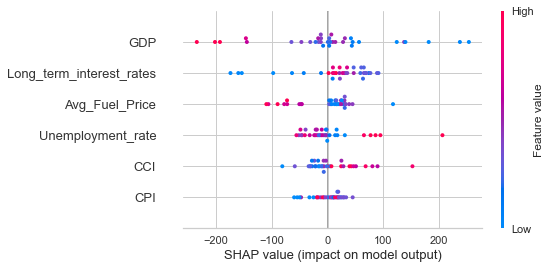

In [78]:
interpret_model(tuned_xgb)

In [79]:
predict_model(tuned_xgb)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extreme Gradient Boosting,108.8188,20150.6324,141.9529,0.1764,0.2482,0.2179


,GDP,CCI,CPI,Unemployment_rate,Long_term_interest_rates,Avg_Fuel_Price,Orders,Label
0,55558.0,97.812790,-0.259687,9.6,0.810000,1.380000,699,536.507568
1,58366.0,98.999512,0.987196,6.8,-0.070000,1.550000,493,436.893951
2,52413.0,98.479347,-0.193085,9.5,0.820000,1.483333,552,593.858704
3,58932.0,102.023102,1.019197,7.3,0.700000,1.506667,507,713.866699
4,57020.0,99.991547,1.260835,7.0,0.380000,1.450000,520,617.058044
5,56983.0,100.864998,0.659275,9.3,0.410000,1.383333,613,676.571960
6,57743.0,101.667297,1.368369,7.2,0.530000,1.526667,675,925.945862
7,59601.0,98.774467,0.916179,6.6,-0.300000,1.523333,484,460.019531
8,53351.0,99.056038,1.610336,8.5,2.030000,1.590000,481,540.335266
9,52107.0,98.797012,0.786891,8.7,1.690000,1.596667,602,606.805908


### Data split

In [80]:
# Select input and target variables
X = data.drop('Orders', axis=1)
y = data["Orders"]

# Split data into train (80%) and test (20%) sets 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Print shape
X_train.shape, X_test.shape 

((112, 6), (28, 6))

### Scoring function

In [184]:
# Importing the metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
#from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

# Importing the modules
import numpy as np
import math
import matplotlib.pyplot as plt

metrics = pd.DataFrame()

def scoring(model_name, model, features, labels):
    
    # Make predictions
    predictions = model.predict(features)
    
    # Calculate metrics
    mae = mean_absolute_error(labels, predictions)             # MAE (Mean Absolute Error)
    mse = mean_squared_error(labels, predictions)              # MSE (Mean Squared Error)
    rmse = math.sqrt(mse)                                      # RMSE (Root Mean Squared Error)
    r2 = r2_score(labels, predictions)                         # R2 (R-squared - Coeficient of determination)
    
    errors = abs(predictions - labels)                         
    mape = 100 * np.mean(errors / labels)                      # MAPE
    accuracy = 100 - mape                                      # Accuracy

    # Append metrics for summary
    metrics[model_name] = [mae, mse, rmse, r2, mape, accuracy]
    metrics.index = ['Mean Absolute Error', 
                    'Mean Squared Error', 
                    'Root Mean Squared Error',
                    'R^2',
                    'Mean Absolute Percentage Error',
                    'Accuracy']
    
    # Print metrics    
    print(model_name, 'Model Performance:')                         # Model name
    print('Mean Absolute Error: {:0.4f}.'.format(mae))              # MAE
    print('Mean Squared Error: {:0.4f}.'.format(mse))               # MSE
    print('Root Mean Squared Error: {:0.4f}.'.format(rmse))         # RMSE  
    print('R^2 Score = {:0.4f}.'.format(r2))                        # R2
    print('Mean Absolute Percentage Error: {:0.4f}.'.format(mape))  # MAPE 
    print('Accuracy = {:0.2f}%.'.format(accuracy))                  # Accuracy

    # Plot Actual values vs predicted values
    plt.figure(figsize=(12, 8))    

    df = pd.DataFrame(y_test)    
    
    plt.plot(df.index,y_test, c='r', label="Actual values")                      # Acutal values
    plt.plot(df.index,predictions, c='b', label="Predicted values", ls='--')     # Predicted values    
    plt.title('Actual vs Predictions with ' + model_name)                        # Title
    plt.xlabel('Date')                                                              
    plt.ylabel('Orders')                                                             
    plt.xticks(rotation=90)
    plt.legend()
    plt.show()        

### XGBoost (Extreme Gradient Boosting)

#### Baseline

XGboost version: 1.7.2
XGBRegressor Model Performance:
Mean Absolute Error: 125.3602.
Mean Squared Error: 19341.8203.
Root Mean Squared Error: 139.0749.
R^2 Score = -1.3181.
Mean Absolute Percentage Error: 50.9709.
Accuracy = 49.03%.


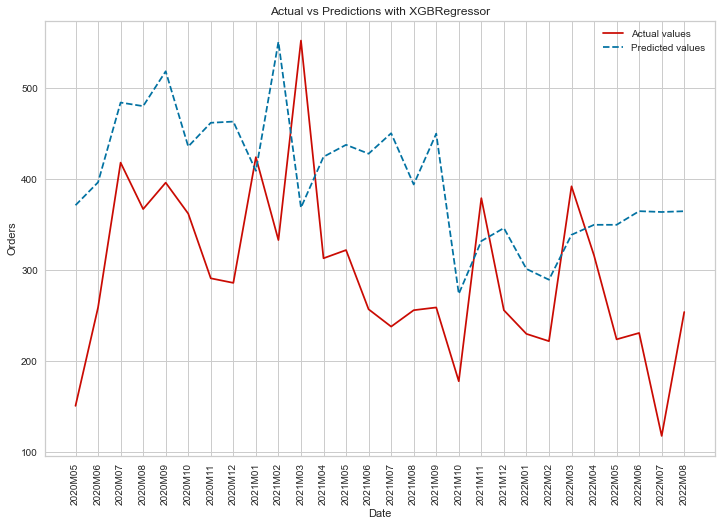

In [185]:
import xgboost as xgb

# Check xgboost version
print("XGboost version:", xgb.__version__)

# Import XGBRegressor
from xgboost import XGBRegressor         
          
# Instantiate the regressor
model = XGBRegressor(random_state=42)

# Fit the regressor to the training data
model.fit(X_train, y_train)

# Compute and print model score
scoring(model.__class__.__name__, model , X_test, y_test)

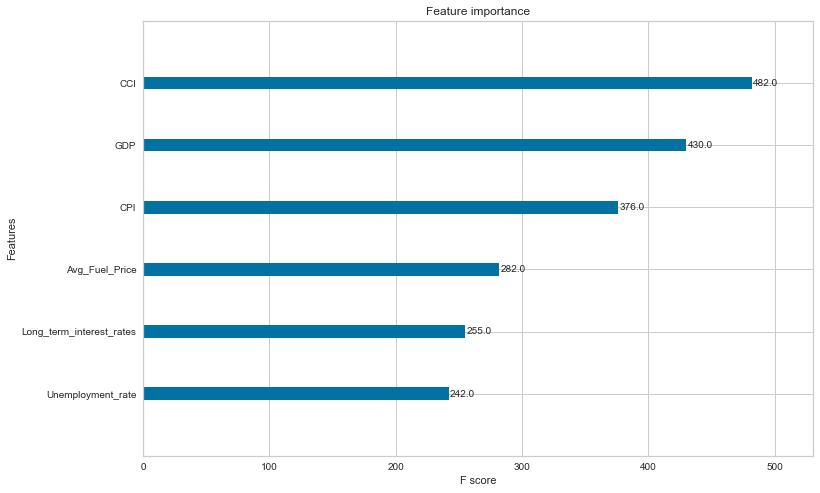

In [85]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 10})

fig, ax = plt.subplots(figsize=(12,8))
plot_importance(model, ax=ax)
plt.show();

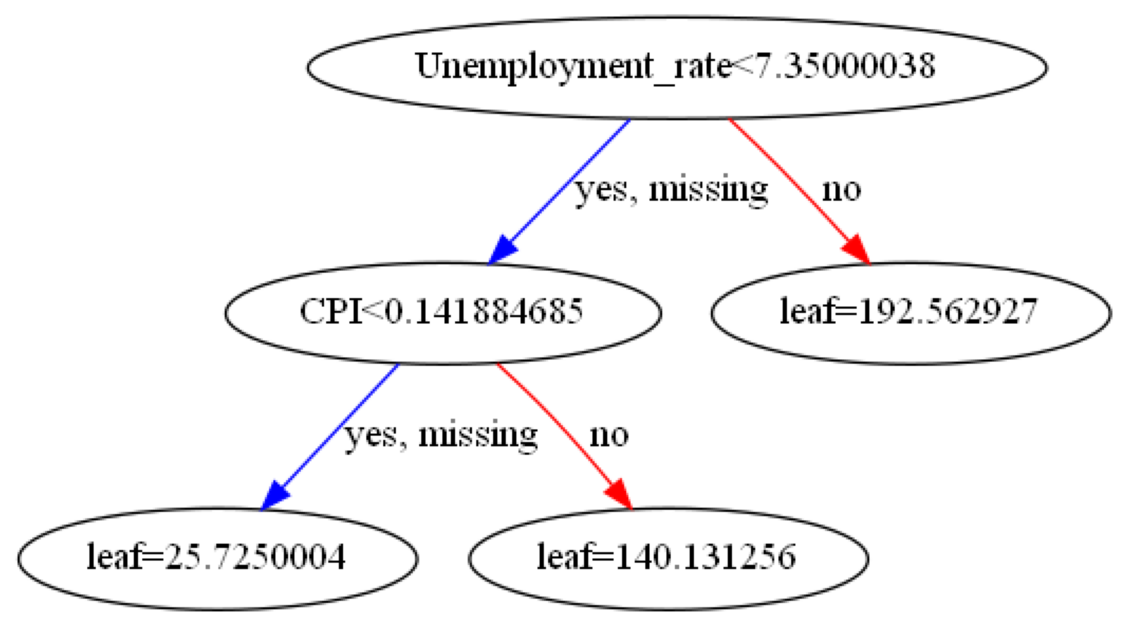

In [86]:
fig, ax = plt.subplots(figsize=(20, 20))
xgb.plot_tree(model, ax=ax)
plt.show()

In [87]:
model

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, objective='reg:squarederror',
             predictor='auto', ...)

#### Hyperparameters Tuning

In [88]:
from sklearn.model_selection import GridSearchCV

# Set hyperparameters possibilities for model tuning
xgb_n_estimators = [100, 500, 1000]
xgb_max_depth = [4, 6, 8, 10]
xgb_min_child_weight = [1, 3, 5 , 7]
xgb_eta = [0.001, 0.01, 0.1, 0.2, 0.3]
xgb_subsample = [0.9, 0.5, 0.2, 0.1]
xgb_objective = ['reg:squarederror', 'reg:squaredlogerror']

# Create the grid
param_grid = {'n_estimators': xgb_n_estimators,
            'max_depth': xgb_max_depth,
            'min_child_weight': xgb_min_child_weight,
            'eta': xgb_eta,
            'subsample': xgb_subsample,
            'objective': xgb_objective}

# Tune the Model
model_base = XGBRegressor(random_state=42)

model_grid = GridSearchCV(estimator = model_base, param_grid = param_grid, cv = 4, verbose = 1, n_jobs=-1)

model_grid.fit(X_train, y_train)

model_grid.best_params_

print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",model_grid.best_estimator_)
print("\n The best score across ALL searched params:\n",model_grid.best_score_)
print("\n The best parameters across ALL searched params:\n",model_grid.best_params_)

Fitting 4 folds for each of 1920 candidates, totalling 7680 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 482 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 756 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 1456 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done 2356 tasks      | elapsed:   40.2s
[Parallel(n_jobs=-1)]: Done 3456 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 4756 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 6256 tasks      | elapsed:  1.9min


 Results from Grid Search 

 The best estimator across ALL searched params:
 XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False, eta=0.1,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.100000001, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=4, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, objective='reg:squarederror', ...)

 The best score across ALL searched params:
 0.027745719511580585

 The best parameters across ALL searched params:
 {'eta': 0.1, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 100, 'objective': 'reg:squar

[Parallel(n_jobs=-1)]: Done 7680 out of 7680 | elapsed:  2.3min finished


#### Tuned Model

XGBRegressor Tuned
XGBRegressor Tuned Model Performance:
Mean Absolute Error: 201.3918.
Mean Squared Error: 49432.5749.
Root Mean Squared Error: 222.3344.
R^2 Score = -4.9245.
Mean Squared Log Error: 0.4221.
Root Mean Squared Log Error: 0.6497.
Mean Absolute Percentage Error: 86.2240.
Accuracy = 13.78%.


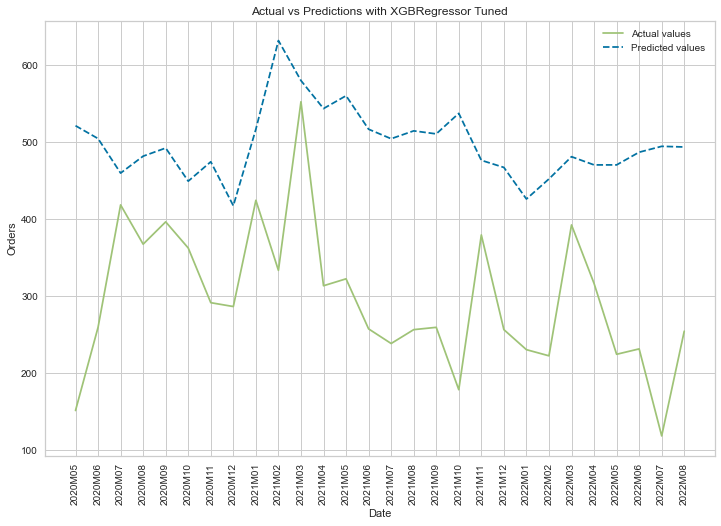

In [89]:
# Create the fnal Extreme Gradient Booster
model_tuned = XGBRegressor(objective = 'reg:squarederror',
                         n_estimators = 100,
                         min_child_weight = 1,
                         max_depth = 4,                         
                         subsample = 0.1,
                         eta = 0.1,
                         random_state = 42)

# Fit the regressor to the training data
model_tuned.fit(X_train, y_train)

# Compute and print model score
model_name = model_tuned.__class__.__name__ + ' Tuned'
print(model_name)
scoring(model_name, model_tuned, X_test, y_test)

### LightGBM Regression

#### Baseline

LigthGBM version: 3.3.4
LGBMRegressor Model Performance:
Mean Absolute Error: 223.4486.
Mean Squared Error: 61082.2308.
Root Mean Squared Error: 247.1482.
R^2 Score = -6.3207.
Mean Squared Log Error: 0.4665.
Root Mean Squared Log Error: 0.6830.
Mean Absolute Percentage Error: 92.8378.
Accuracy = 7.16%.


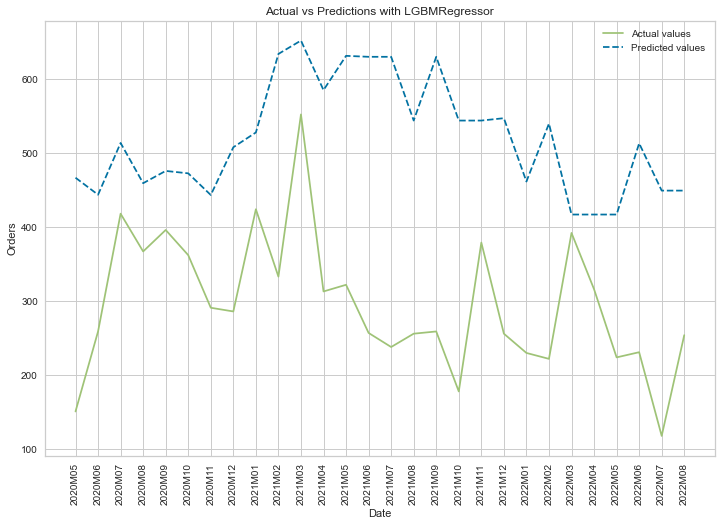

In [90]:
import lightgbm as lgbm

# Check ligthGBM version
print("LigthGBM version:", lgbm.__version__)

# Import LightGBM Regressor
from lightgbm import LGBMRegressor
          
# Instantiate the regressor
model = LGBMRegressor(random_state=42)

# Fit the regressor to the training data
model.fit(X_train, y_train)

# Compute and print model score
scoring(model.__class__.__name__, model , X_test, y_test)

In [91]:
model

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

#### Hyperparameters Tuning

In [92]:
from sklearn.model_selection import GridSearchCV

# Set hyperparameters possibilities for model tuning
lgbm_n_estimators = [100, 500, 1000]
lgbm_max_depth = [4, 6, 8, 10]
lgbm_num_leaves = [1, 3, 5 , 7]
lgbm_learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
lgbm_subsample = [0.9, 0.5, 0.2, 0.1]

# Create the grid
param_grid = {'n_estimators': lgbm_n_estimators,
            'max_depth': lgbm_max_depth,
            'num_leaves': lgbm_num_leaves,
            'learning_rate': lgbm_learning_rate,
            'subsample': lgbm_learning_rate
           }

# Tune the Model
model_base = LGBMRegressor(random_state=42)

model_grid = GridSearchCV(estimator = model_base, param_grid = param_grid, cv = 4, verbose = 1, n_jobs=-1)

model_grid.fit(X_train, y_train)

model_grid.best_params_

print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",model_grid.best_estimator_)
print("\n The best score across ALL searched params:\n",model_grid.best_score_)
print("\n The best parameters across ALL searched params:\n",model_grid.best_params_)

Fitting 4 folds for each of 1728 candidates, totalling 6912 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 404 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 1404 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done 2804 tasks      | elapsed:   30.0s
[Parallel(n_jobs=-1)]: Done 4604 tasks      | elapsed:   39.8s
[Parallel(n_jobs=-1)]: Done 6804 tasks      | elapsed:   50.5s


 Results from Grid Search 

 The best estimator across ALL searched params:
 LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.01, max_depth=4,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=500, n_jobs=-1, num_leaves=5, objective=None,
              random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
              subsample=0.0001, subsample_for_bin=200000, subsample_freq=0)

 The best score across ALL searched params:
 -0.10861814223129498

 The best parameters across ALL searched params:
 {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 500, 'num_leaves': 5, 'subsample': 0.0001}


[Parallel(n_jobs=-1)]: Done 6912 out of 6912 | elapsed:   51.5s finished


#### Tuned Model

LGBMRegressor Tuned
LGBMRegressor Tuned Model Performance:
Mean Absolute Error: 223.0653.
Mean Squared Error: 57721.4002.
Root Mean Squared Error: 240.2528.
R^2 Score = -5.9179.
Mean Squared Log Error: 0.4577.
Root Mean Squared Log Error: 0.6765.
Mean Absolute Percentage Error: 92.4436.
Accuracy = 7.56%.


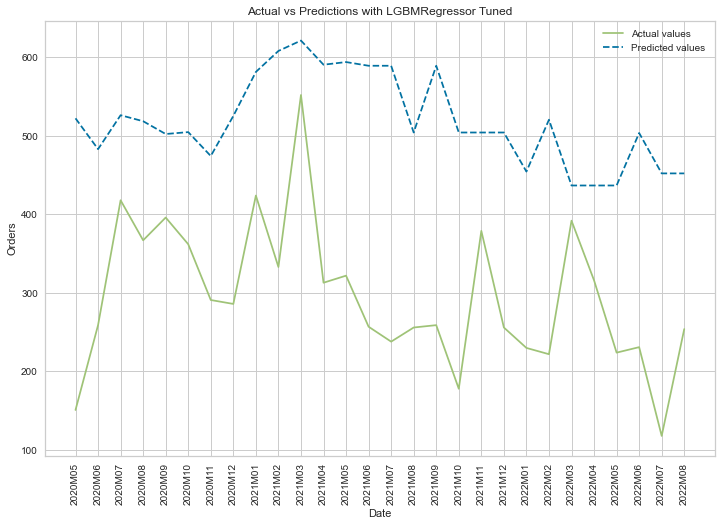

In [93]:
# Create the fnal LightGBM Model
model_tuned = LGBMRegressor(n_estimators = 500,
                         num_leaves= 5,
                         max_depth = 4,                         
                         subsample = 0.0001,
                         learning_rate= 0.01,
                         random_state = 42)

# Fit the regressor to the training data
model_tuned.fit(X_train, y_train)

# Compute and print model score
model_name = model_tuned.__class__.__name__ + ' Tuned'
print(model_name)
scoring(model_name, model_tuned, X_test, y_test)

### Random Forest Regression

#### Baseline

RandomForestRegressor Model Performance:
Mean Absolute Error: 145.1639.
Mean Squared Error: 26377.5928.
Root Mean Squared Error: 162.4118.
R^2 Score = -2.1558.
Mean Squared Log Error: 0.2627.
Root Mean Squared Log Error: 0.5125.
Mean Absolute Percentage Error: 61.0253.
Accuracy = 38.97%.


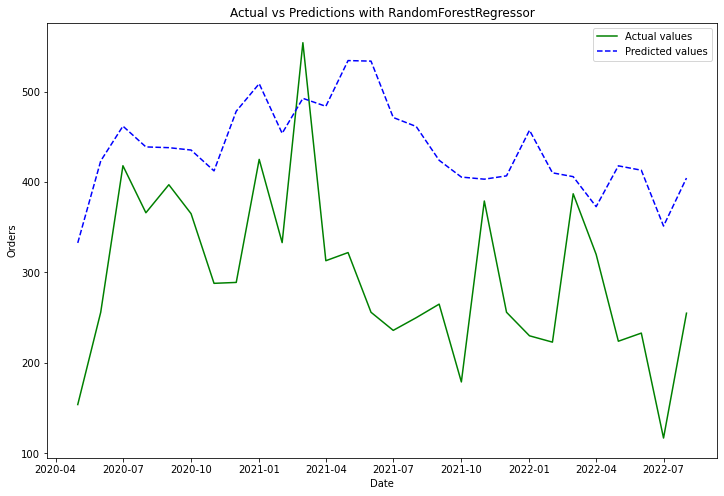

In [69]:
# Import Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor
          
# Instantiate the regressor
model = RandomForestRegressor(random_state=42)

# Fit the regressor to the training data
model.fit(X_train, y_train)

# Compute and print model score
scoring(model.__class__.__name__, model , X_test, y_test)

In [70]:
model

RandomForestRegressor(random_state=42)

#### Hyperparameters Tuning

In [71]:
from sklearn.model_selection import GridSearchCV

# Set hyperparameters possibilities for model tuning 
rf_n_estimators = [100, 500, 1000]
rf_max_depth = [4, 6, 8, 10]
rf_max_features = ['auto', 'sqrt']
rf_min_samples_leaf = [1, 2, 4]
rf_min_samples_split = [2, 5, 10]
rf_bootstrap = [True, False]

# Create the grid
param_grid = {'n_estimators': rf_n_estimators,
           'max_depth': rf_max_depth,
           'max_features': rf_max_features,
           'min_samples_leaf': rf_min_samples_leaf,
           'min_samples_split': rf_min_samples_split,
           'bootstrap': rf_bootstrap
        }

# Tune the Model
model_base = RandomForestRegressor(random_state=42)

model_grid = GridSearchCV(estimator = model_base, param_grid = param_grid, cv = 4, verbose = 1, n_jobs=-1)

model_grid.fit(X_train, y_train)

model_grid.best_params_

print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",model_grid.best_estimator_)
print("\n The best score across ALL searched params:\n",model_grid.best_score_)
print("\n The best parameters across ALL searched params:\n",model_grid.best_params_)

Fitting 4 folds for each of 432 candidates, totalling 1728 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  3.0min


 Results from Grid Search 

 The best estimator across ALL searched params:
 RandomForestRegressor(max_depth=8, min_samples_leaf=2, min_samples_split=10,
                      random_state=42)

 The best score across ALL searched params:
 0.028845345356432683

 The best parameters across ALL searched params:
 {'bootstrap': True, 'max_depth': 8, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}


[Parallel(n_jobs=-1)]: Done 1728 out of 1728 | elapsed:  4.0min finished


#### Tuned Model

RandomForestRegressor Tuned
RandomForestRegressor Tuned Model Performance:
Mean Absolute Error: 150.5736.
Mean Squared Error: 28557.8136.
Root Mean Squared Error: 168.9906.
R^2 Score = -2.4167.
Mean Squared Log Error: 0.2876.
Root Mean Squared Log Error: 0.5363.
Mean Absolute Percentage Error: 64.6067.
Accuracy = 35.39%.


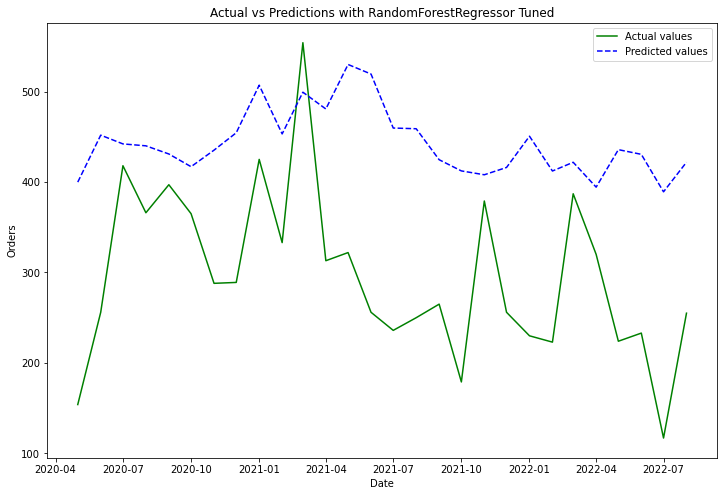

In [72]:
# Create the fnal Random Forest Regressor Model
model_tuned = RandomForestRegressor(n_estimators = 100,
                         max_depth = 8,                         
                         max_features = 'auto',
                         min_samples_leaf= 2,
                         min_samples_split = 10,
                         bootstrap = True,
                         random_state = 42)

# Fit the regressor to the training data
model_tuned.fit(X_train, y_train)

# Compute and print model score
model_name = model_tuned.__class__.__name__ + ' Tuned'
print(model_name)
scoring(model_name, model_tuned, X_test, y_test)

## Summary

In [73]:
metrics

,XGBRegressor,XGBRegressor Tuned,LGBMRegressor,LGBMRegressor Tuned,RandomForestRegressor,RandomForestRegressor Tuned
Mean Absolute Error,110.201332,157.115278,128.514080,137.997399,145.163929,150.573636
Mean Squared Error,17548.644245,31778.883339,22210.227609,26259.681917,26377.592846,28557.813619
Root Mean Squared Error,132.471296,178.266327,149.030962,162.048394,162.411800,168.990573
R^2,-1.099534,-2.802051,-1.657250,-2.141730,-2.155837,-2.416680
Mean Squared Log Error,0.185415,0.307903,0.232637,0.268632,0.262700,0.287633
Root Mean Squared Log Error,0.430598,0.554890,0.482324,0.518297,0.512543,0.536314
Mean Absolute Percentage Error,46.729228,67.692136,54.856525,60.308521,61.025307,64.606669
Accuracy,53.270772,32.307864,45.143475,39.691479,38.974693,35.393331


# Other tests

### XGBoost (Extreme Gradient Boosting)

XGB Model Performance:
Mean Absolute Error: 125.3602.
Mean Squared Error: 19341.8203.
Root Mean Squared Error: 139.0749.
R^2 Score = -1.3181.
Mean Squared Log Error: 0.2011.
Root Mean Squared Log Error: 0.4484.
Mean Absolute Percentage Error: 50.9709.
Accuracy = 49.03%.


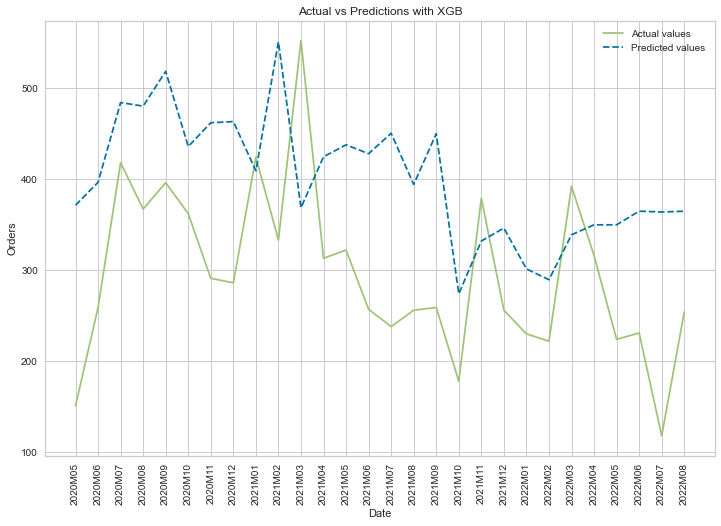

In [95]:
import xgboost as xgb
from xgboost import XGBRegressor
xgb_regressor = XGBRegressor(random_state=42)
xgb = xgb_regressor.fit(X_train, y_train)

scoring("XGB", xgb, X_test, y_test)

In [97]:
xgb.feature_importances_

array([0.18910074, 0.07774591, 0.24029268, 0.19292125, 0.17414135,
       0.12579808], dtype=float32)

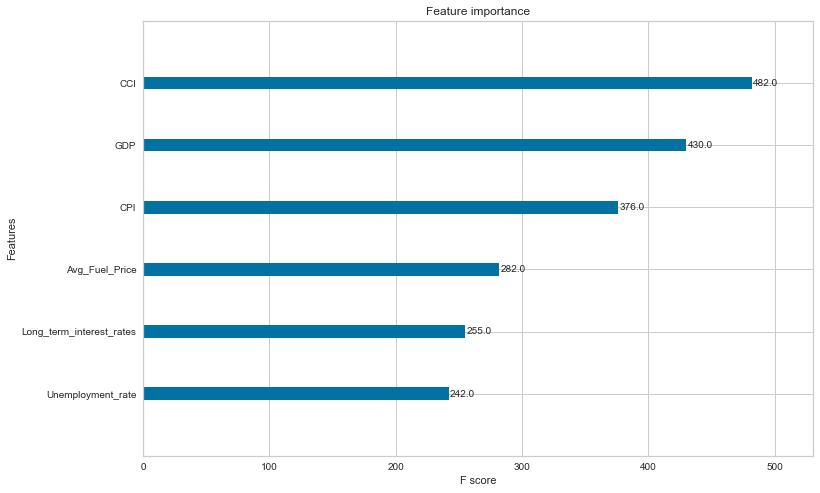

In [100]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 10})

fig, ax = plt.subplots(figsize=(12,8))
plot_importance(xgb, ax=ax)
plt.show();

### Cross-validation

In [129]:
from sklearn.model_selection import cross_val_score
import numpy as np
# Import Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor

# Define a function that compares the CV perfromance of a set of predetrmined models 
def cv_comparison(models, X, y, cv):
    cv_accuracies = pd.DataFrame()
    maes = []
    mses = []
    r2s = []
    accs = []
    
    # Loop through the models, run a CV, add the average scores to the DataFrame and the scores of all CVs to the list
    for model in models:
        mae = -np.round(cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv), 4)
        maes.append(mae)
        mae_avg = round(mae.mean(), 4)
        mse = -np.round(cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv), 4)
        mses.append(mse)
        mse_avg = round(mse.mean(), 4)
        r2 = np.round(cross_val_score(model, X, y, scoring='r2', cv=cv), 4)
        r2s.append(r2)
        r2_avg = round(r2.mean(), 4)
        acc = np.round((100 - (100 * (mae * len(X))) / sum(y)), 4)
        accs.append(acc)
        acc_avg = round(acc.mean(), 4)
        cv_accuracies[model.__class__.__name__] = [mae_avg, mse_avg, r2_avg, acc_avg]
    cv_accuracies.index = ['Mean Absolute Error', 'Mean Squared Error', 'R^2', 'Accuracy']
    return cv_accuracies, maes, mses, r2s, accs

# Create the models to be tested
mlgbm = lgbm.LGBMRegressor()
rf_reg = RandomForestRegressor(random_state=42)
xgb_reg = xgb_regressor = XGBRegressor(random_state=42)

#models = [mlgbm, rf_reg, xgb_reg]
models = [mlgbm, rf_reg, xgb_reg]

# Run the 10 Fold Cross-Validation comparison with the models used in this analysis
comp, maes, mses, r2s, accs = cv_comparison(models, X_train, y_train, 10)

comp

,LGBMRegressor,RandomForestRegressor,XGBRegressor
Mean Absolute Error,124.9471,134.5706,161.1689
Mean Squared Error,29062.9648,32277.8150,45928.3848
R^2,-0.2887,-0.6835,-1.3528
Accuracy,79.5900,78.0181,73.6733


In [130]:
# Run the 10 Fold Cross-Validation comparison with the models used in this analysis
comp, maes, mses, r2s, accs = cv_comparison(models, X_test, y_test, 10)

comp

,LGBMRegressor,RandomForestRegressor,XGBRegressor
Mean Absolute Error,78.6376,76.5052,80.8159
Mean Squared Error,9373.3210,11176.1533,11033.4681
R^2,-48.6369,-18.5144,-91.4678
Accuracy,73.4204,74.1412,72.6841


In [154]:
r2_comp = pd.DataFrame(r2s, index=comp.columns, columns=['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4','Fold 5', 'Fold 6', 'Fold 7', 'Fold 8', 'Fold 9', 'Fold 10'])
r2_comp['Average'] = np.round(r2_comp.mean(axis=1),len(r2s[0]))
r2_comp

,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Fold 6,Fold 7,Fold 8,Fold 9,Fold 10,Average
LGBMRegressor,-0.0411,-34.9720,-0.4391,-1.1460,-0.5366,-3.7529,-0.0168,-0.0519,-442.3857,-3.0270,-48.63691
RandomForestRegressor,-1.6081,-3.0115,-0.3575,-1.3502,0.1843,-6.6921,-1.4051,-1.7937,-168.2067,-0.9031,-18.51437
XGBRegressor,-1.6404,-9.5846,-0.3193,-0.3960,-0.6744,-4.5882,-1.7584,-2.1400,-893.1388,-0.4379,-91.46780


### Hyperparameters Tuning - Random Forest

In [112]:
# Set hyperparameters possibilities for tuning Random Forest
rf_n_estimators = [int(x) for x in np.linspace(200, 1000, 5)]
rf_max_depth = [int(x) for x in np.linspace(5, 55, 11)]
rf_max_depth.append(None)
rf_max_features = ['auto', 'sqrt', 'log2']
rf_criterion = ['mse', 'absolute_error']
rf_min_samples_split = [int(x) for x in np.linspace(2, 10, 9)]
rf_min_impurity_decrease = [0.0, 0.05, 0.1]
rf_bootstrap = [True, False]

# Create the grid
rf_grid = {'n_estimators': rf_n_estimators,
               'max_depth': rf_max_depth,
               'max_features': rf_max_features,
               'criterion': rf_criterion,
               'min_samples_split': rf_min_samples_split,
               'min_impurity_decrease': rf_min_impurity_decrease,
               'bootstrap': rf_bootstrap}

rf_grid

{'n_estimators': [200, 400, 600, 800, 1000],
 'max_depth': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, None],
 'max_features': ['auto', 'sqrt', 'log2'],
 'criterion': ['mse', 'absolute_error'],
 'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10],
 'min_impurity_decrease': [0.0, 0.05, 0.1],
 'bootstrap': [True, False]}

In [113]:
from sklearn.model_selection import RandomizedSearchCV
# Tune the Random Forest Model
rf_base = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf_base, param_distributions = rf_grid, 
                               n_iter = 200, cv = 3, verbose = 2, random_state = 42, 
                               n_jobs = -1)

rf_random.fit(X_train, y_train)

rf_random.best_estimator_

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:   36.8s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   58.8s finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=40, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.05,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=9, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

### Hyperparameters Tuning - XGBoost (Extreme Gradient Boosting)

In [114]:
# Set hyperparameters possibilities for tuning XGBoost
xgb_n_estimators = [int(x) for x in np.linspace(200, 1000, 5)]
xgb_max_depth = [int(x) for x in np.linspace(2, 20, 10)]
xgb_min_child_weight = [int(x) for x in np.linspace(1, 10, 10)]
xgb_tree_method = ['auto', 'exact', 'approx', 'hist'
]
xgb_eta = [x for x in np.linspace(0.1, 0.6, 6)]
xgb_gamma = [int(x) for x in np.linspace(0, 0.5, 6)]
xgb_objective = ['reg:squarederror', 'reg:squaredlogerror']

# Create the grid
xgb_grid = {'n_estimators': xgb_n_estimators,
            'max_depth': xgb_max_depth,
            'min_child_weight': xgb_min_child_weight,
            'tree_method': xgb_tree_method,
            'eta': xgb_eta,
            'gamma': xgb_gamma,
            'objective': xgb_objective}

# Tune the XGBoost Model
xgb_base = XGBRegressor()

xgb_random = RandomizedSearchCV(estimator = xgb_base, param_distributions = xgb_grid, 
                                n_iter = 200, cv = 3, verbose = 2, 
                                random_state = 42, n_jobs = -1)

xgb_random.fit(X_train, y_train)

xgb_random.best_params_

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   14.9s finished


{'tree_method': 'hist',
 'objective': 'reg:squarederror',
 'n_estimators': 600,
 'min_child_weight': 7,
 'max_depth': 16,
 'gamma': 0,
 'eta': 0.5}

### Final Evaluation

In [117]:
# Create the final LigthGBM

# Create the final Random Forest
rf_final = RandomForestRegressor(n_estimators = 200,
                                 min_impurity_decrease = 0.0,
                                 max_features = 'sqrt',
                                 max_depth = 20,
                                 criterion = 'mse',
                                 bootstrap = True,
                                 random_state = 42)

# Create the fnal Extreme Gradient Booster
xgb_final = XGBRegressor(tree_method = 'hist',
                         objective = 'reg:squarederror',
                         n_estimators = 600,
                         min_child_weight = 7,
                         max_depth = 16,
                         gamma = 0,
                         eta = 0.5,
                         random_state = 42)

# Train the models using 80% of the original data
# LGBM goes here --
rf_final.fit(X_train, y_train)
xgb_final.fit(X_train, y_train)

# Define a function that compares all final models
def final_comparison(models, test_features, test_labels):
    scores = pd.DataFrame()
    for model in models:
        predictions = model.predict(test_features)
        mae = round(mean_absolute_error(test_labels, predictions), 4)
        mse = round(mean_squared_error(test_labels, predictions), 4)
        r2 = round(r2_score(test_labels, predictions), 4)
        errors = abs(predictions - test_labels)
        mape = 100 * np.mean(errors / test_labels)
        accuracy = round(100 - mape, 4)
        scores[str(model)] = [mae, mse, r2, accuracy]
    scores.index = ['Mean Absolute Error', 'Mean Squared Error', 'R^2', 'Accuracy']
    return scores
    
# Run the Cross-Validation comparison with the models used in this analysis
final_models = [rf_final, xgb_final]
comp, maes, mses, r2s, accs = cv_comparison(final_models, X_train, y_train, 4)

comp

,"RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',\n max_depth=20, max_features='sqrt', max_leaf_nodes=None,\n max_samples=None, min_impurity_decrease=0.0,\n min_impurity_split=None, min_samples_leaf=1,\n min_samples_split=2, min_weight_fraction_leaf=0.0,\n n_estimators=200, n_jobs=None, oob_score=False,\n random_state=42, verbose=0, warm_start=False)","XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,\n colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,\n early_stopping_rounds=None, enable_categorical=False, eta=0.5,\n eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,\n grow_policy='depthwise', importance_type=None,\n interaction_constraints='', learning_rate=0.5, max_bin=256,\n max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,\n max_depth=16, max_leaves=0, min_child_weight=7, missing=nan,\n monotone_constraints='()', n_estimators=600, n_jobs=0,\n num_parallel_tree=1, objective='reg:squarederror', ...)"
Mean Absolute Error,137.4804,151.1757
Mean Squared Error,33936.4372,41766.7069
R^2,-0.1978,-0.5325
Accuracy,77.5428,75.3056


RandomForestRegressor Model Performance:
Mean Absolute Error: 229.7393.
Mean Squared Error: 61555.7104.
Root Mean Squared Error: 248.1042.
R^2 Score = -6.3774.
Mean Squared Log Error: 0.4845.
Root Mean Squared Log Error: 0.6961.
Mean Absolute Percentage Error: 96.4181.
Accuracy = 3.58%.


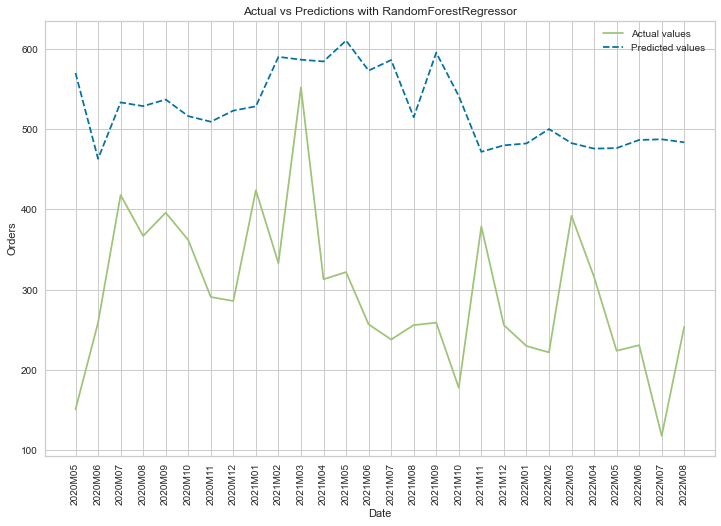

XGBRegressor Model Performance:
Mean Absolute Error: 257.3108.
Mean Squared Error: 74605.3933.
Root Mean Squared Error: 273.1399.
R^2 Score = -7.9415.
Mean Squared Log Error: 0.5269.
Root Mean Squared Log Error: 0.7259.
Mean Absolute Percentage Error: 103.8365.
Accuracy = -3.84%.


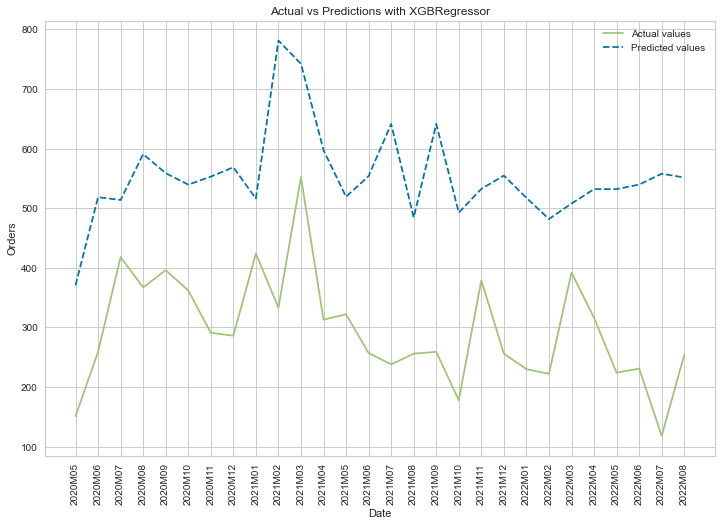

In [118]:
for model in final_models:
    scoring(model.__class__.__name__, model, X_test, y_test)

### XGBoost (Extreme Gradient Boosting)

In [119]:
import xgboost as xgb

# check xgboost version
print(xgb.__version__)

# Select input and target variables
X = data.drop(['Orders'], axis=1)
y = data["Orders"]

# Create the DMatrix 
dmatrix = xgb.DMatrix(data=X, label=y)

# Definiing params
params={"objective":"reg:squarederror","max_depth":4}

# L1 regularization
reg_params = [1,10,100]
rmses_l1=[]

for reg in reg_params:
    params["alpha"] = reg
    cv_results = xgb.cv(dtrain=dmatrix, params=params,nfold=4,num_boost_round=10,metrics="rmse",as_pandas=True,seed=123)
    rmses_l1.append(cv_results["test-rmse-mean"].tail(1).values[0])

print("Best rmse as a function of l1:")
print(pd.DataFrame(list(zip(reg_params,rmses_l1)), columns=["l1","rmse"]))

# Create an empty list for storing rmses as a function of l2 complexity
rmses_l2 = []

# L2 regularization
for reg in reg_params:

    # Update l2 strength
    params["lambda"] = reg
    
    # Pass this updated param dictionary into cv
    cv_results_rmse = xgb.cv(dtrain=dmatrix, params=params, nfold=2, num_boost_round=5, metrics="rmse", as_pandas=True, seed=123)
    
    # Append best rmse (final round) to rmses_l2
    rmses_l2.append(cv_results_rmse["test-rmse-mean"].tail(1).values[0])

# Look at best rmse per l2 param
print("Best rmse as a function of l2:")
print(pd.DataFrame(list(zip(reg_params, rmses_l2)), columns=["l2", "rmse"]))

1.7.2
Best rmse as a function of l1:
    l1        rmse
0    1  162.313482
1   10  158.493091
2  100  160.170547
Best rmse as a function of l2:
    l2        rmse
0    1  197.874925
1   10  219.053827
2  100  352.537560


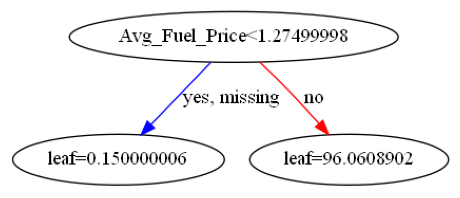

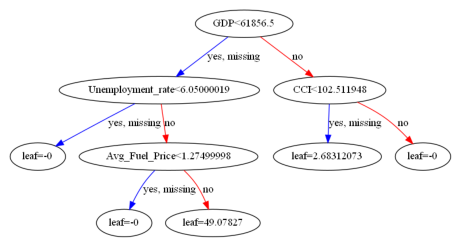

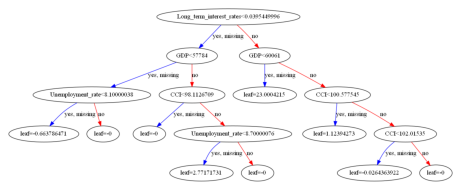

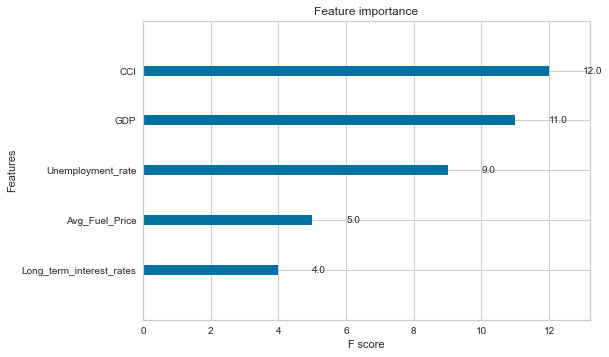

In [121]:
# Train the model: xg_reg
xg_reg = xgb.train(params=params, dtrain=dmatrix, num_boost_round=10)

# Plot the first tree
xgb.plot_tree(xg_reg,num_trees=0)
plt.show()

# Plot the fifth tree
xgb.plot_tree(xg_reg,num_trees=4)
plt.show()

# Plot the last tree sideways
xgb.plot_tree(xg_reg,num_trees=9)
plt.show()

# Plot the feature importances
xgb.plot_importance(xg_reg)
plt.show()

### Model tuning

In [122]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

dmatrix = xgb.DMatrix(data=X,label=y)

gbm_param_grid = {'learning_rate': np.arange(0.05,1.05,.05),
                    'n_estimators': [200],
                    'subsample': np.arange(0.05,1.05,.05)}

gbm = xgb.XGBRegressor()

randomized_mse = RandomizedSearchCV(estimator=gbm, param_distributions=gbm_param_grid, n_iter=25, scoring='neg_mean_squared_error', cv=4, verbose=1)
randomized_mse.fit(X, y)
print("Best parameters found: ",randomized_mse.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(randomized_mse.best_score_)))

Fitting 4 folds for each of 25 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters found:  {'subsample': 0.9500000000000001, 'n_estimators': 200, 'learning_rate': 0.8500000000000001}
Lowest RMSE found:  188.08143960338987


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    9.1s finished


In [28]:
# Create the DMatrix
dmatrix = xgb.DMatrix(data=X, label=y)

# Create the parameter dictionary for each tree: params 
params = {"objective":"reg:squarederror", "max_depth":3}

# Create list of number of boosting rounds
num_rounds = [5, 10, 15]

# Empty list to store final round rmse per XGBoost model
final_rmse_per_round = []

# Iterate over num_rounds and build one model per num_boost_round parameter
for curr_num_rounds in num_rounds:

    # Perform cross-validation: cv_results
    cv_results = xgb.cv(dtrain=dmatrix, params=params, nfold=3, num_boost_round=curr_num_rounds, metrics="rmse", as_pandas=True, seed=123)
    
    # Append final round RMSE
    final_rmse_per_round.append(cv_results["test-rmse-mean"].tail().values[-1])

# Print the resultant DataFrame
num_rounds_rmses = list(zip(num_rounds, final_rmse_per_round))
print(pd.DataFrame(num_rounds_rmses,columns=["num_boosting_rounds","rmse"]))

   num_boosting_rounds        rmse
0                    5  183.122624
1                   10  147.596829
2                   15  145.746563


In [21]:
X_train.shape, X_test.shape

((112, 13), (28, 13))

In [29]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

In [24]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

In [25]:
xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_test)

In [27]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 72.653859


In [32]:
params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=42)

In [33]:
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,368.897880,12.618361,368.081924,28.865079
1,337.347801,11.430440,337.864388,30.209572
2,308.618192,10.960824,309.358712,31.367627
3,282.799589,10.193485,283.653487,32.242495
4,259.745429,9.594686,261.709599,32.982860


In [34]:
print((cv_results["test-rmse-mean"]).tail(1))

32    115.488021
Name: test-rmse-mean, dtype: float64


In [35]:
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)

In [22]:
import matplotlib.pyplot as plt

xgb.plot_tree(xg_reg,num_trees=0)
plt.rcParams['figure.figsize'] = [50, 10]
plt.show()

AttributeError: 'XGBRegressor' object has no attribute 'plot_tree'

In [119]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [15, 10]
plt.show()

AttributeError: 'XGBRegressor' object has no attribute 'plot_importance'

## Choosing classifier

In [120]:
from xgboost import XGBRegressor
import xgboost as xgb
#create an xgboost regression model
model = XGBRegressor()

## Fitting the model

In [121]:
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

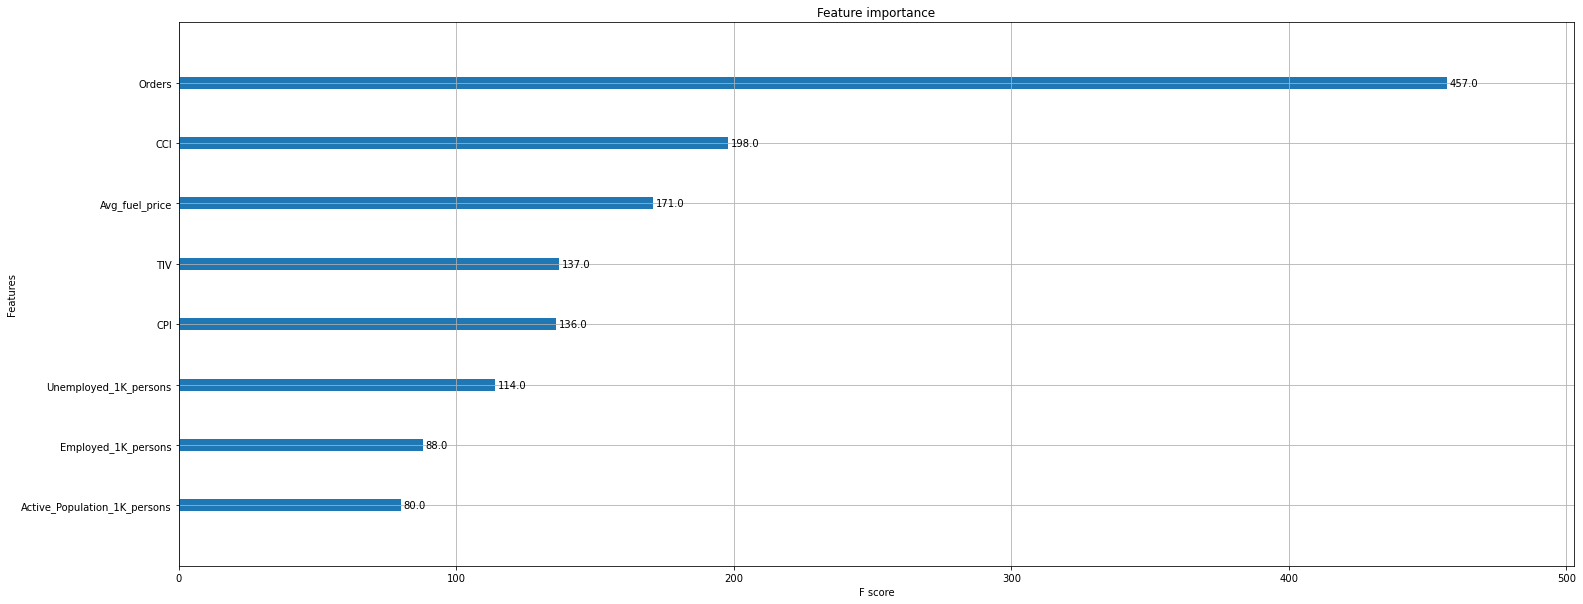

In [122]:
xgb.plot_importance(model, ax=plt.gca())

## Tuning hyperparameters

In [ ]:
# create an xgboost regression model
model = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)

In [26]:
# evaluate an xgboost regression model 
from numpy import absolute
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

# split data into input and output columns
X, y = datavalues[:, :-1], datavalues[:, -1]
# define model
model = XGBRegressor()
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean MAE: 20.692 (7.774)


In [51]:
# Scale the independent variables
from sklearn.preprocessing import StandardScaler
scalerX = StandardScaler().fit(X_train)
X_train_scaled = scalerX.transform(X_train)
X_test_scaled = scalerX.transform(X_test)

In [52]:
import xgboost
reg = xgboost.XGBRegressor(objective='reg:squarederror', \
                           n_estimators=1000, \
                          nthread=24)
reg.fit(X_train_scaled, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=24,
             nthread=24, num_parallel_tree=1, predictor='auto', ...)

In [53]:
predictions_xgb = reg.predict(X_test_scaled)
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse_xgb = sqrt(mean_squared_error(y_test, predictions_xgb))
print("XGBoost - Root Mean Square Error (RMSE): %.3f" % rmse_xgb)

XGBoost - Root Mean Square Error (RMSE): 68.086
